In [9]:
using CSV
using DataFrames
using LinearAlgebra
using Plots
using YAML

In [10]:
# Load the CSV and YAML files
particles = CSV.read("particles.csv", DataFrame)
config = YAML.load_file("config.yaml")
config2 = YAML.load_file("config2.yaml")

Dict{Any, Any} with 4 entries:
  "name"    => "WhitePaper_300k/test/WhitePaper_300k/sim_test_62419_1"
  "creator" => "CORSIKA8"
  "args"    => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/sou…
  "version" => "8.0.0-prealpha"

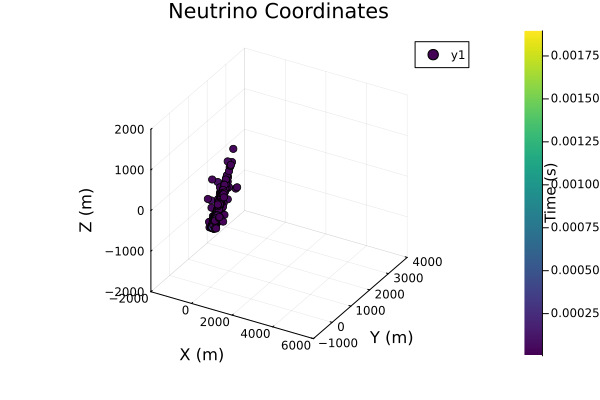

In [31]:
# Define common axis limits
x_limits = (-2000, 6000)
y_limits = (-1000, 4000)
z_limits = (-2000, 2000)

# Define the vectors and rotation matrix
normal_vector = [0.45217398524533681, -0.3661629880519191, 0.81330397346148509]
x_axis = [0.0, -0.91184756344828699, -0.41052895273466672]
y_axis = [0.89192975455881607, 0.18563051261662877, -0.41231374670066206]

rotation_matrix = hcat(x_axis, y_axis, normal_vector)

# Add a 'z' column initialized to 0
particles[!, :z] = zeros(size(particles, 1))

# Extract the columns as vectors and stack them into a matrix
coords = hcat(particles.x, particles.y, particles.z)'

# Apply the rotation matrix
rotated_positions = rotation_matrix * coords

# Take the inverse of the rotation matrix
inverse_rotation_matrix = inv(rotation_matrix)

# Apply the inverse rotation matrix to get back original coordinates
original_positions = inverse_rotation_matrix * rotated_positions

# Assign the original positions back to the DataFrame
particles.x = original_positions[1, :]
particles.y = original_positions[2, :]
particles.z = original_positions[3, :]

# Neutrino Coordinates Plot
plot1 = scatter3d(particles.x, particles.y, particles.z, 
                  xlabel="X (m)", ylabel="Y (m)", zlabel="Z (m)", 
                  xlims=x_limits, ylims=y_limits, zlims=z_limits,
                  title="Neutrino Coordinates", 
                  marker_z=particles.time, color=:viridis, colorbar=true, 
                  colorbar_title="Time (s)")


Plane Center: Real[0, 0, 6.373992525515844e6]
Plane Normal: [0.4521739852453368, -0.3661629880519191, 0.8133039734614851]
X-axis: Real[0, -0.911847563448287, -0.4105289527346667]
Y-axis: [0.8919297545588161, 0.18563051261662877, -0.41231374670066206]


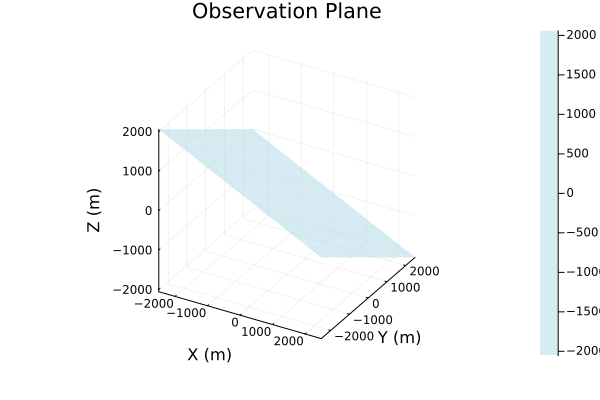

In [24]:
# Extract the plane information
plane_center = config["plane"]["center"]
plane_normal = config["plane"]["normal"]
x_axis = config["x-axis"]
y_axis = config["y-axis"]

# Display the extracted values
println("Plane Center: ", plane_center)
println("Plane Normal: ", plane_normal)
println("X-axis: ", x_axis)
println("Y-axis: ", y_axis)

# Define constants
radius_of_earth = 6.371e6  # in meters
elevation_of_origin = 2992  # in meters

# Define the plane grid
x_range = range(-2500, 2500, length=10)
y_range = range(-2500, 2500, length=10)
xx, yy = [plane_center[1] + x_axis[1]*x + y_axis[1]*y for x in x_range, y in y_range], 
          [plane_center[2] + x_axis[2]*x + y_axis[2]*y for x in x_range, y in y_range]
zz = [plane_center[3] + x_axis[3]*x + y_axis[3]*y - radius_of_earth - elevation_of_origin for x in x_range, y in y_range]

# Plot the Observation Plane
plot2 = surface(x_range, y_range, zz, alpha=0.5, color=:lightblue, label="Observation Plane")

# Add labels and title for the Observation Plane
xlabel!(plot2, "X (m)")
ylabel!(plot2, "Y (m)")
zlabel!(plot2, "Z (m)")
title!(plot2, "Observation Plane")


YAML content:
Dict{Any, Any}("name" => "WhitePaper_300k/test/WhitePaper_300k/sim_test_62419_1", "creator" => "CORSIKA8", "args" => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/corsika8/corsika-work/corsika --pdg -211 --energy 134431.50919983155 --zenith 99.99732787664736 --azimuth 203.76835088101396 --xpos 5.82690291372798 --ypos 2.651239329640523 --zpos -0.7696777502523529 -f WhitePaper_300k/test/WhitePaper_300k/sim_test_62419_1 --xdir 0.4521739852453368 --ydir -0.3661629880519191 --zdir 0.8133039734614851 -O 2.9925255158436626 --force-interaction --x-intercept -1.9042410053751477 --y-intercept -0.7535013903260498 --z-intercept 0.7194652218340803 --emcut 1 --mucut 1 --hadcut 1 ", "version" => "8.0.0-prealpha")
Zenith: 99.99732787664736
Azimuth: 203.76835088101396
X Position: 5826.90291372798
Y Position: 2651.2393296405226
Z Position: -769.6777502523529
Vector in Cartesian coordinates: (-0.9012861721003252, -0.3969200111396664, -0.17360224865372587)


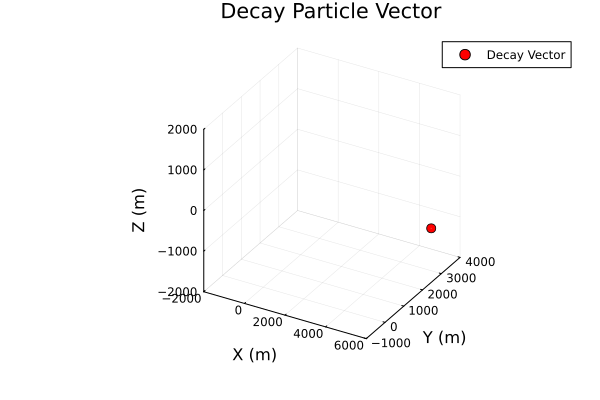

In [32]:
# Print the entire YAML content
println("YAML content:")
println(config2)

# Extract the necessary values from the "args" string
args = config2["args"]

# Function to extract parameter values from the "args" string
function extract_param(args::String, param::String)
    pattern = Regex("$param (\\S+)")
    match_result = match(pattern, args)
    return match_result !== nothing ? parse(Float64, match_result.captures[1]) : nothing
end

zenith = extract_param(args, "--zenith")
azimuth = extract_param(args, "--azimuth")
xpos = extract_param(args, "--xpos") * 1000  # Convert to meters
ypos = extract_param(args, "--ypos") * 1000  # Convert to meters
zpos = extract_param(args, "--zpos") * 1000  # Convert to meters

# Display the extracted values
println("Zenith: ", zenith)
println("Azimuth: ", azimuth)
println("X Position: ", xpos)
println("Y Position: ", ypos)
println("Z Position: ", zpos)

# Convert zenith and azimuth from degrees to radians
zenith_rad = deg2rad(zenith)
azimuth_rad = deg2rad(azimuth)

# Convert spherical to Cartesian coordinates
vx = sin(zenith_rad) * cos(azimuth_rad)
vy = sin(zenith_rad) * sin(azimuth_rad)
vz = cos(zenith_rad)

# Display the Cartesian coordinates of the vector
println("Vector in Cartesian coordinates: (", vx, ", ", vy, ", ", vz, ")")

# Decay Particle Vector Plot
plot3 = scatter3d([xpos], [ypos], [zpos], 
                  xlabel="X (m)", ylabel="Y (m)", zlabel="Z (m)", 
                  xlims=x_limits, ylims=y_limits, zlims=z_limits,
                  title="Decay Particle Vector", 
                  markersize=5, color=:red, label="Decay Vector")
quiver!(plot3, [xpos], [ypos], [zpos], quiver=([vx], [vy], [vz]), 
        arrow=true, label="")


┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/carlitos/.julia/packages/Plots/ju9dp/src/backends/gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/carlitos/.julia/packages/Plots/ju9dp/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/carlitos/.julia/packages/Plots/ju9dp/src/backends/gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/carlitos/.julia/packages/Plots/ju9dp/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/carlitos/.julia/packages/Plots/ju9dp/src/backends/gr.jl:528
┌ Warning: Multiple series wit

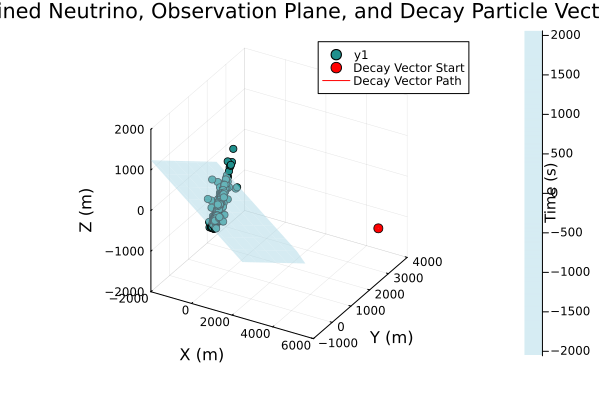

In [33]:
# Create the combined plot
plot_combined = scatter3d(particles.x, particles.y, particles.z, 
                          xlabel="X (m)", ylabel="Y (m)", zlabel="Z (m)", 
                          xlims=x_limits, ylims=y_limits, zlims=z_limits,
                          title="Combined Neutrino, Observation Plane, and Decay Particle Vector", 
                          marker_z=particles.time, color=:viridis, colorbar=true, 
                          colorbar_title="Time (s)")

# Add the observation plane to the plot
surface!(plot_combined, x_range, y_range, zz, alpha=0.5, color=:lightblue, label="Observation Plane")

# Add the decay particle vector to the plot
scatter3d!([xpos], [ypos], [zpos], markersize=5, color=:red, label="Decay Vector Start")
quiver!([xpos], [ypos], [zpos], quiver=([vx], [vy], [vz]), arrow=true, label="Decay Vector")

# Plot the path of the decay vector for better visibility
num_points = 10
path_x = xpos .+ vx * range(0, 10, length=num_points)
path_y = ypos .+ vy * range(0, 10, length=num_points)
path_z = zpos .+ vz * range(0, 10, length=num_points)

plot3d!(path_x, path_y, path_z, label="Decay Vector Path", color=:red)

# Display the combined plot
display(plot_combined)
